In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from salishsea_tools import viz_tools, geo_tools
import arrow
from pathlib import Path

In [2]:
grid_dir = Path("/ocean/atall/MOAD/grid/")
grid_map = Path("grid_from_lat_lon_mask999.nc")
grid_lons_lats = xr.open_dataset(grid_dir / grid_map)
meshmask = xr.open_dataset('/ocean/atall/MOAD/grid/mesh_mask_202310b.nc')
tmask = meshmask.tmask
mbathy = meshmask.mbathy


In [14]:
# Constant and data rang
syear = 2018
eyear = 2019
smonth = 1
emonth = 3
startdate = arrow.get(syear, smonth, 1)
enddate = arrow.get(eyear, emonth, 5)
print (startdate, enddate)

2018-01-01T00:00:00+00:00 2019-03-05T00:00:00+00:00


... at the bottom


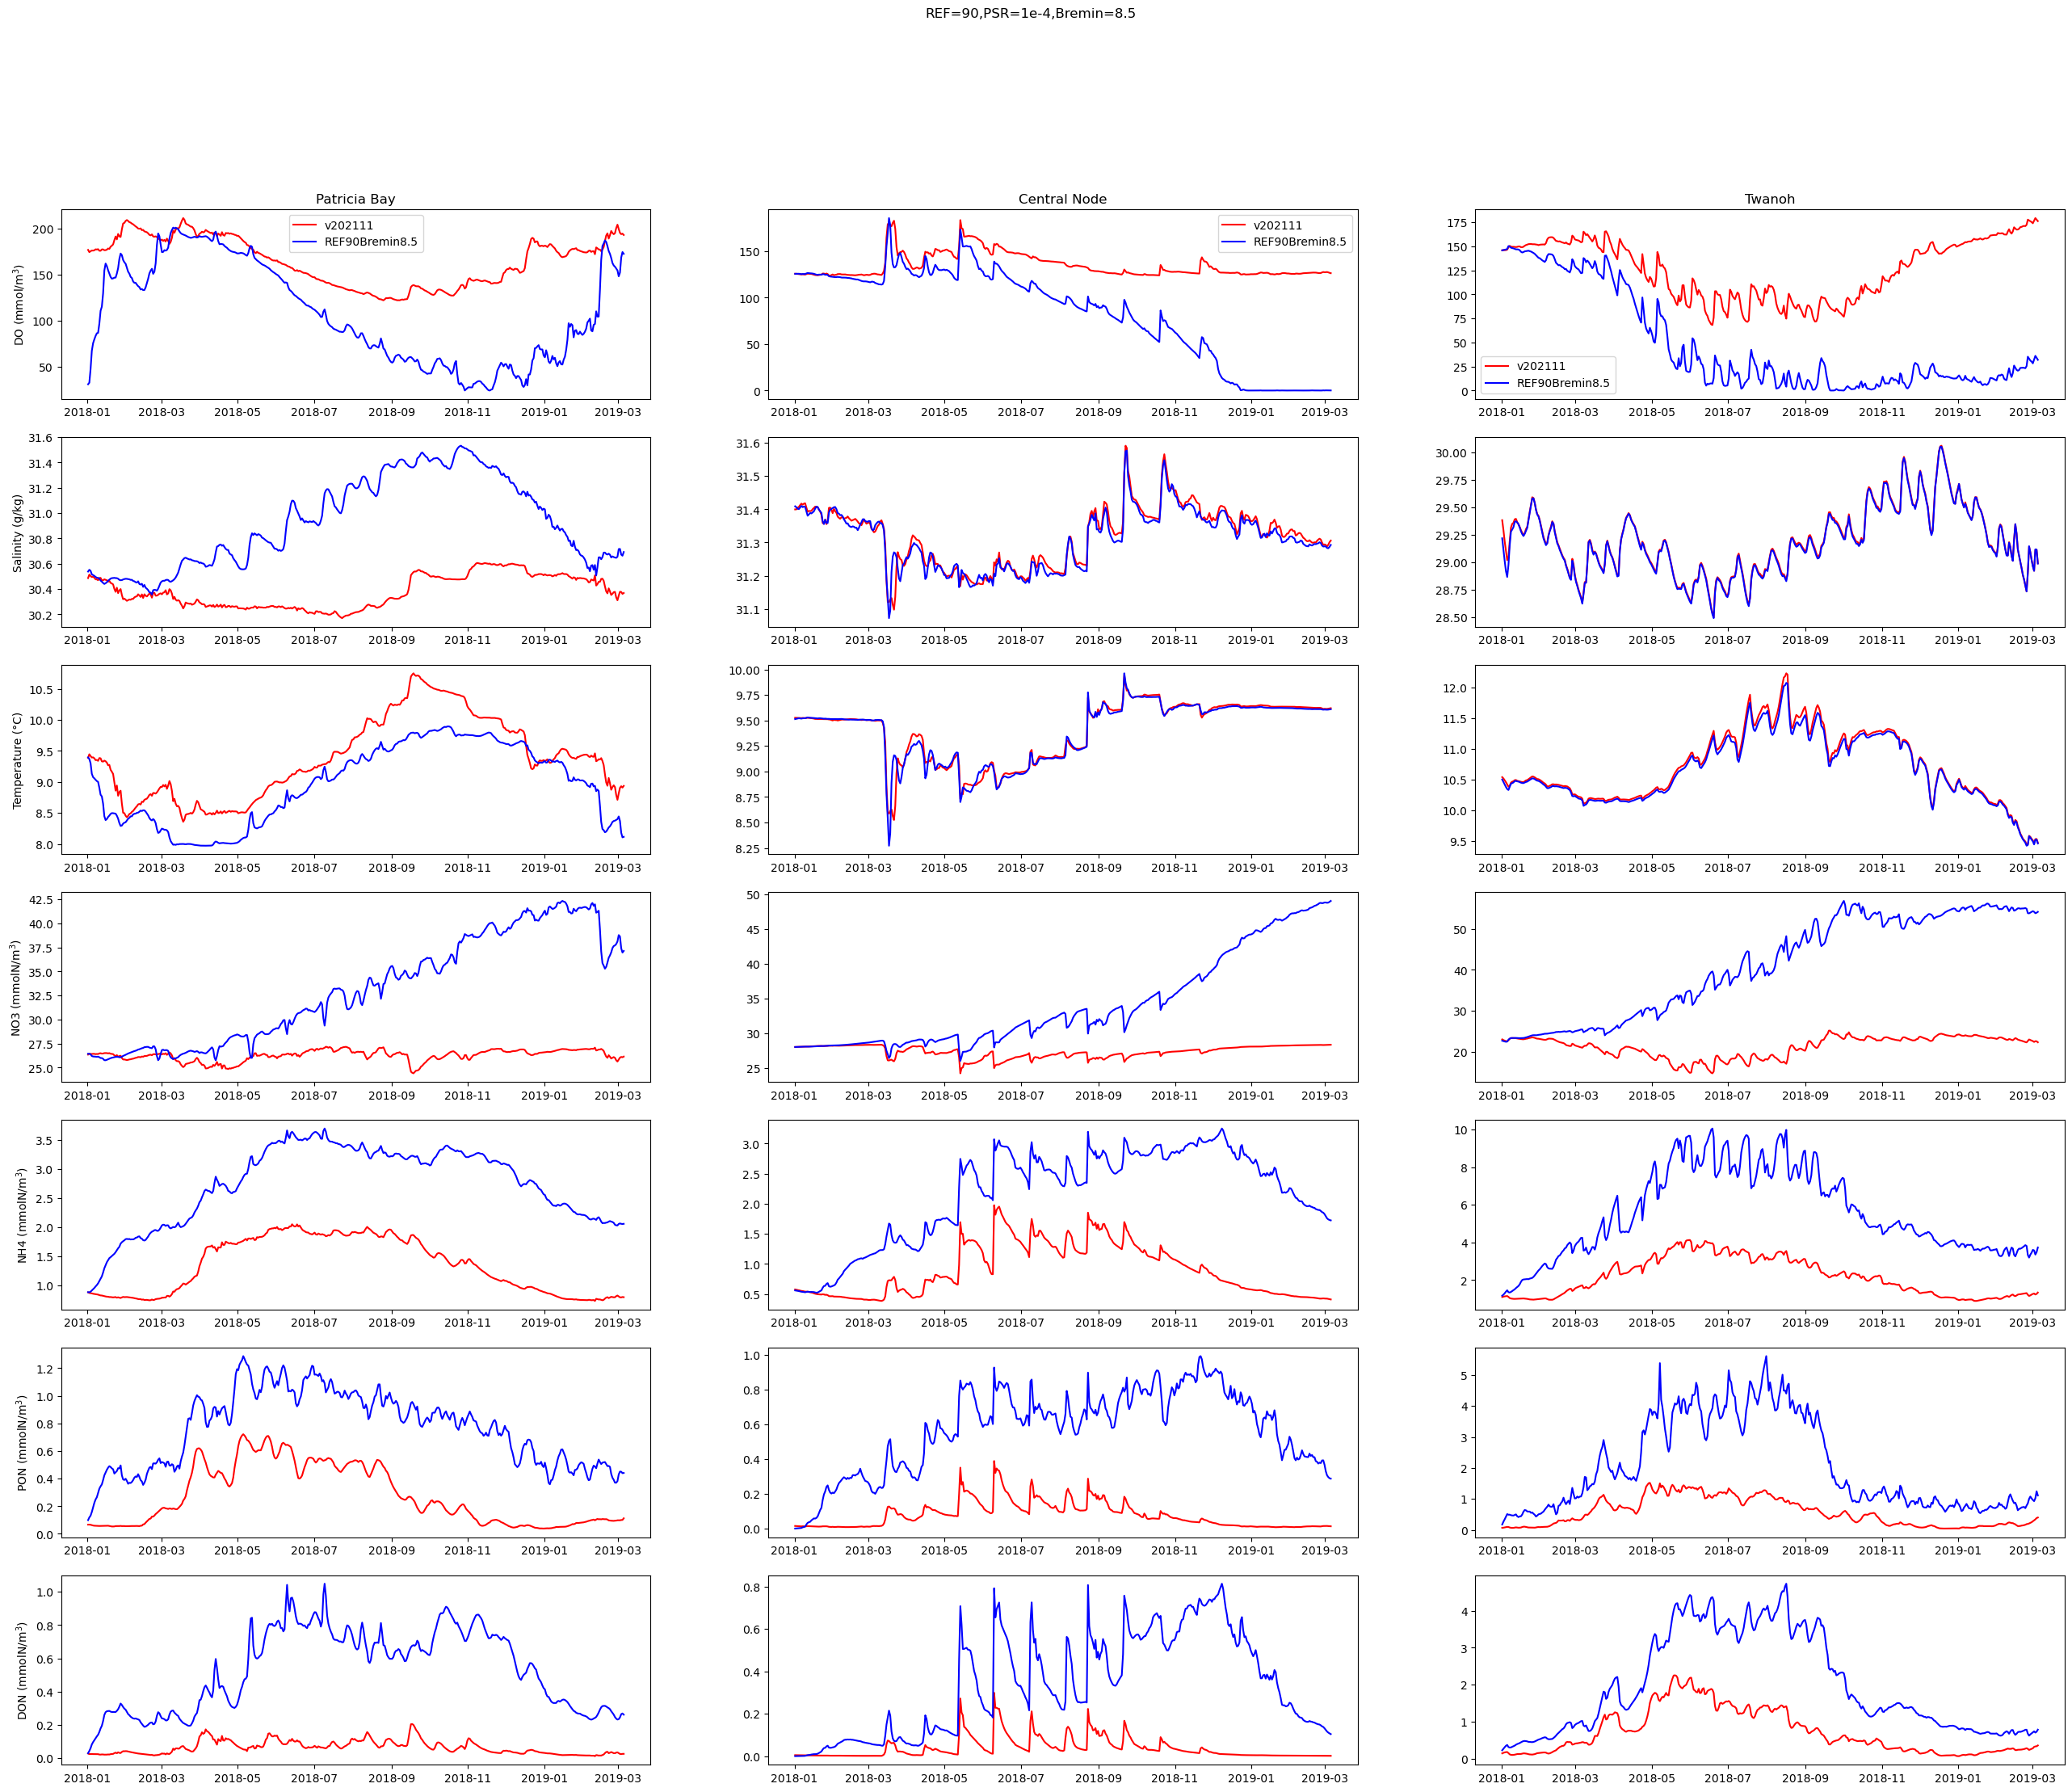

In [15]:
print('... at the bottom')
line, col = (7, 3)
fig, ax = plt.subplots(line, col, figsize=(32, 25))
ylabel = list(['DO (mmol/m$^3$)','Salinity (g/kg)','Temperature (°C)','NO3 (mmolN/m$^3$)','NH4 (mmolN/m$^3$)','PON (mmolN/m$^3$)','DON (mmolN/m$^3$)','SMS (mmolO$_2$/m$^3$/s)'])
place = list(['Patricia Bay','Central Node','Twanoh'])
for alpha in range(0, 2):
    if alpha == 0:
        dir = '/results2/SalishSea/nowcast-green.202111/'
        colors = 'r'
        labels = 'v202111'
    
    for j in range(0, col):
        if j==0:
            jj, ii = (353, 209)
        elif j==1:
            jj, ii = (423, 266)
        else:
            jj, ii = (72, 123)   
        first = True
        for iii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
            year = day.year
            yr2 = day.strftime("%y")
            month = day.month
            Month = day.strftime("%b").lower()
            day = day.day
            # set up filename to follow NEMO conventions
            fchem90 = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc'
            with xr.open_dataset(fchem90) as ds_chem90:
                oxy0 = ds_chem90['dissolved_oxygen'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
            fbiol90 = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_biol_T.nc'
            with xr.open_dataset(fbiol90) as ds_biol90:
                nit0 = ds_biol90['nitrate'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
                amm0 = ds_biol90['ammonium'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
                pon0 = ds_biol90['particulate_organic_nitrogen'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
                don0 = ds_biol90['dissolved_organic_nitrogen'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
            fgrdT90 = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_T.nc'
            with xr.open_dataset(fgrdT90) as ds_grdT90:
                sal0 = ds_grdT90['vosaline'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
                tem0 = ds_grdT90['votemper'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
            if first:
                first = False
                oxy = oxy0
                pon = pon0
                don = don0
                nit = nit0
                amm = amm0
                tem = tem0
                sal = sal0
            else:
                oxy = xr.concat([oxy, oxy0], dim='time_counter')
                nit = xr.concat([nit, nit0], dim='time_counter')
                amm = xr.concat([amm, amm0], dim='time_counter')
                pon = xr.concat([pon, pon0], dim='time_counter')
                don = xr.concat([don, don0], dim='time_counter')
                sal = xr.concat([sal, sal0], dim='time_counter')
                tem = xr.concat([tem, tem0], dim='time_counter')

        for i  in range(0, line):
            if i==0:
                var = oxy
            elif i==1:
                var = sal
            elif i==2:
                var = tem
            elif i==3:
                var = nit
            elif i==4:
                var = amm
            elif i==5:
                var = pon
            elif i==6:
                var = don

            ax[i,j].plot(var.time_counter, var, color=colors, label=labels)
            ax[0,j].legend()
            ax[i,0].set_ylabel(f'{ylabel[i]}')
            ax[0,j].set_title(f'{place[j]}')
            ax[i,j].grid()
    else:
        dir = '/ocean/sallen/timbucktwo/oxygen/'
        colors = 'b'
        labels = 'REF90Bremin8.5'
    fig.suptitle(f'REF=90,PSR=1e-4,Bremin=8.5')
